In [118]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

In [2]:
# Reset pseudo random number generator so that the results are reproducible.
seed = 42
np.random.seed(seed)

## Generating the target function and its noisy version.

In [3]:
# Sets the number of examples.
N = 30
# Attribute.
x = np.sort(2*np.random.rand(N, 1) - 1, axis=0)
# Target function.
y = 1 + 0.5*x + 2*(x**2)
# Noisy function.
y_noisy = y + 0.3*np.random.randn(N, 1)

Ntest = 100
x_test = np.linspace(-1, 1, Ntest).reshape(Ntest, 1)
y_test = 1 + 0.5*x_test + 2*(x_test**2) + 0.3*np.random.randn(Ntest, 1)

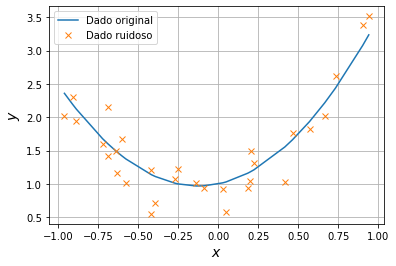

In [4]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("target_function.png", dpi=600)
#Show the plot.
plt.show()

## Define the polinomial order

In [5]:
# Polynomial order.
model_order = 15

## Define the regularization factor

In [6]:
# Regularization factor.
lambdas = [0, 0.656, 1000]

## Manually Implemented Closed-form solution

É importante escalonar os dados (por exemplo, usando a classe StandardScaler) antes de realizar a regressão de Ridge, pois ela é bastante sensível à escala dos atributos.

**OBS**.: É importante escalonar os atributos antes de executar a regressão de Ridge, pois ela é sensível à escala dos atributos.

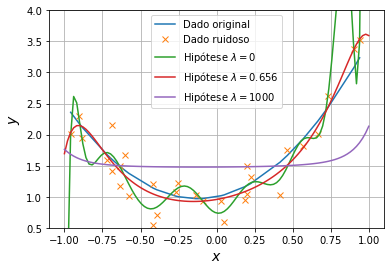

In [7]:
# Concatenate both column vectors.
X = np.ones((N,1))
for i in range(1, model_order+1):
    X = np.c_[X, np.power(x, i)]

# Instantiate standard scaler. 
scaler = StandardScaler()

# Train and standardize samples.
X = np.c_[np.ones((N,1)), scaler.fit_transform(X[:,1:])]

# Concatenate both column vectors.
X_test = np.ones((Ntest,1))
for i in range(1, model_order+1):
    X_test = np.c_[X_test, np.power(x_test, i)]

# Standardize validation samples.
X_test = np.c_[np.ones((Ntest,1)), scaler.transform(X_test[:,1:])]

I = np.eye(model_order+1)
I[0,0] = 0

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
for i in range(0,len(lambdas)):
    # Closed-form solution.
    a_opt = np.linalg.pinv(np.transpose(X).dot(X) + I.dot(lambdas[i])).dot(np.transpose(X).dot(y_noisy))
    # Predict.
    y_pred_test = X_test.dot(a_opt)
    # Plot prediction.
    plt.plot(x_test, y_pred_test, label='Hipótese $\lambda=$'+str(lambdas[i]))
    
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
#Show the plot.
plt.show()

## Closed-form solution with SciKit-Learn 

Documentação da classe Ridge:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

O solver=‘cholesky’ usa a função scipy.linalg.solve padrão para obter uma solução de forma fechada.

Essa solução é equivalente à implementada manualmente.

Porém, existem outros solvers. Verifique a documentação da classe Ridge.

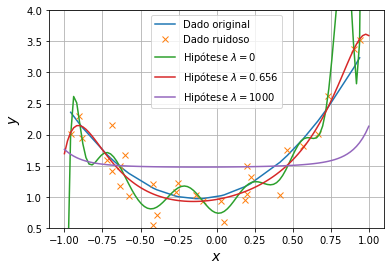

In [8]:
include_bias = True

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
for i in range(0,len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Ridge(alpha=lambdas[i], solver="cholesky")
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    # Predict.
    y_test_regul = model.predict(x_test)
    # Plot prediction.
    plt.plot(x_test, y_test_regul, label='Hipótese $\lambda=$'+str(lambdas[i]))
    
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
# Save figure
plt.savefig("ridge_regression.png", dpi=600)
#Show the plot.
plt.show()

## Weight variation versus lambda

In [9]:
include_bias = True

M = 10000
lambdas = np.linspace(1e-3,100, M)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Ridge(alpha=lambdas[i], solver="cholesky")
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_[0,1:model_order+1]
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a)
    # Predict.
    y_test_regul = model.predict(x_test)
    error_test.append((mean_squared_error(y_test, y_test_regul)))

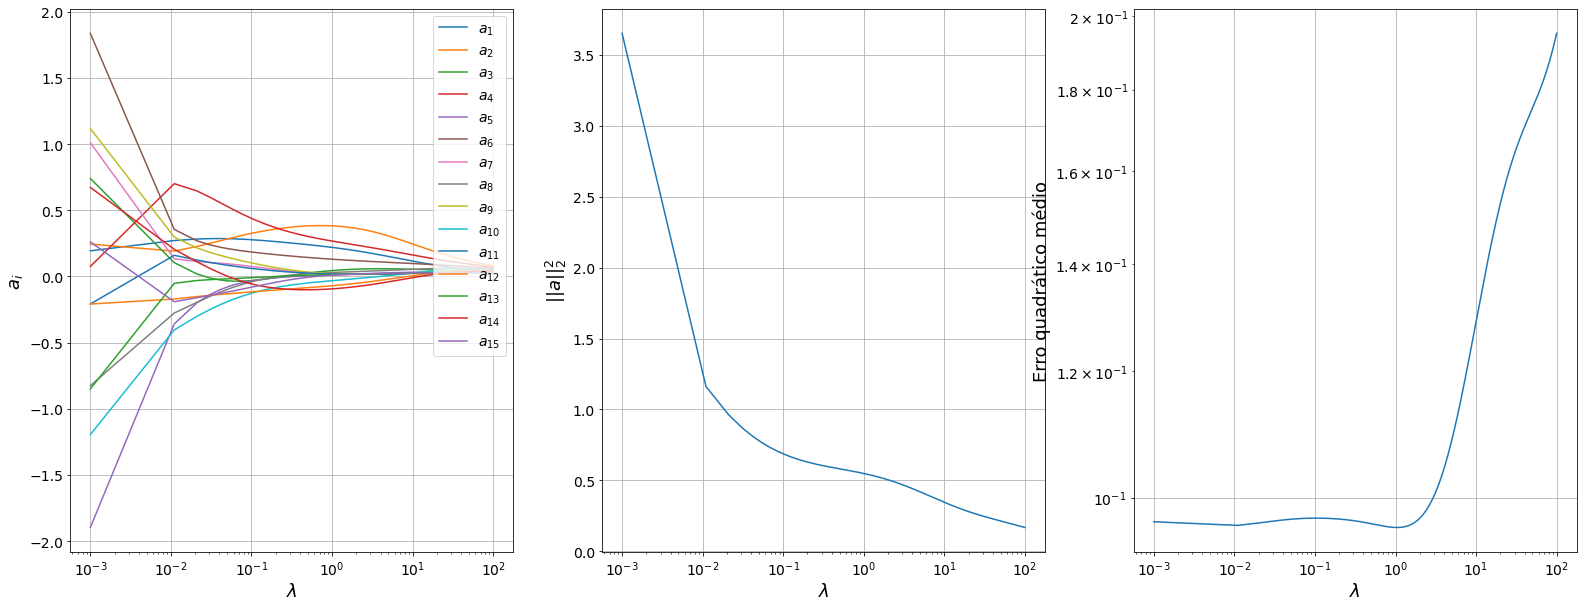

In [10]:
# Create figure.
fig = plt.figure(figsize=(27,10))

# Plot weight.
ax = plt.subplot(1, 3, 1)
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
ax.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$a_i$', fontsize=18)
plt.legend(loc='upper right', fontsize=14)
plt.grid()

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
ax.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$||a||_2^2$', fontsize=18)
plt.grid()

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_test)
ax.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('Erro quadrático médio', fontsize=18)
plt.grid()

#Show the plot.
plt.show()

ax.tick_params(reset=True)

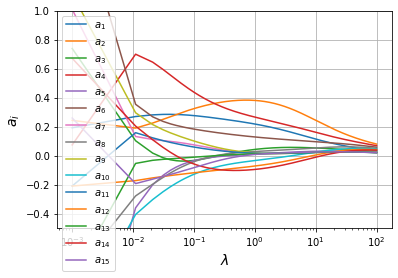

In [11]:
# Plot weight.
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper left')
plt.ylim([-0.5, 1])
plt.grid()
#Show the plot.
plt.show()

### RidgeCV for finding the best $\lambda$

In [12]:
M = 10000
alphas = np.logspace(-5,2,M)

clf = RidgeCV(alphas=alphas)
clf.fit(X, y_noisy)
clf.score(X, y_noisy)

0.8848349641387636

In [13]:
clf.alpha_

0.6553625918127431

In [14]:
alphas = np.linspace(clf.alpha_/10,clf.alpha_*10,M)

clf = RidgeCV(alphas=alphas)
clf.fit(X, y_noisy)
clf.score(X, y_noisy)

0.8848327842239769

In [15]:
clf.alpha_

0.656011465666023

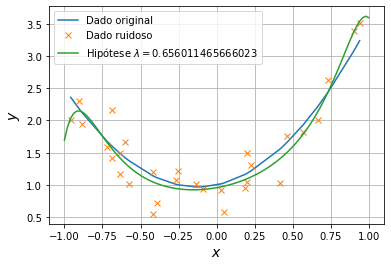

In [16]:
y_test_pred = clf.predict(X_test)

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(x_test, y_test_pred, label='Hipótese $\lambda=$'+str(clf.alpha_))
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.axis([-1, 0, 1])
#Show the plot.
plt.show()

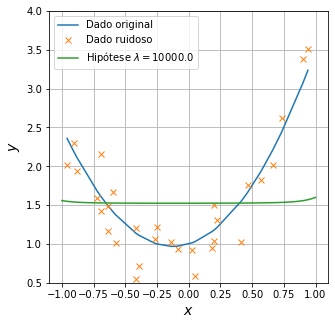

In [88]:
lambdas = 1e4
# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X) + I.dot(lambdas)).dot(np.transpose(X).dot(y_noisy))
# Predict.
y_pred_test = X_test.dot(a_opt)

# Plot original data versus noisy version.
plt.figure(figsize=(5,5))
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(x_test, y_pred_test, label='Hipótese $\lambda=$'+str(lambdas))
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
plt.savefig('ridge_regression_lambda'+str(lambdas)+'.png', dpi=600)
#Show the plot.
plt.show()

In [90]:
include_bias = True

M = 10000
lambdas = np.linspace(1e-3,100, M)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Ridge(alpha=lambdas[i], solver="cholesky")
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_[0,1:model_order+1]
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a)
    # Predict.
    y_test_regul = model.predict(x_test)
    error_test.append((mean_squared_error(y_test, y_test_regul)))

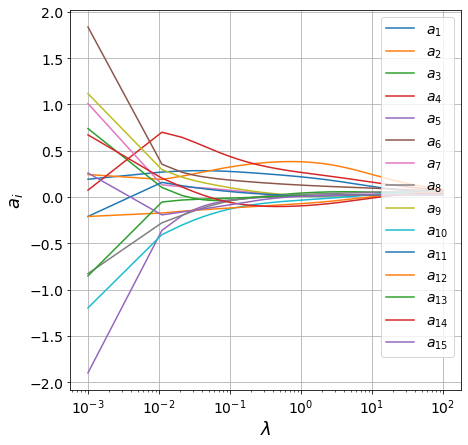

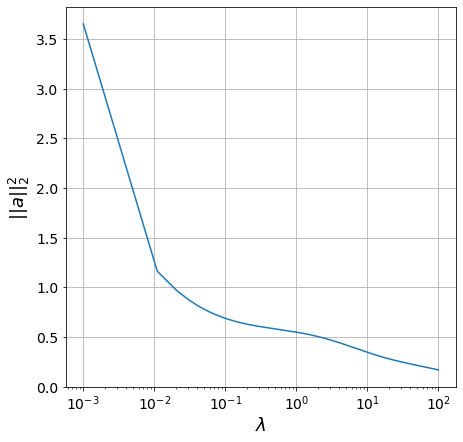

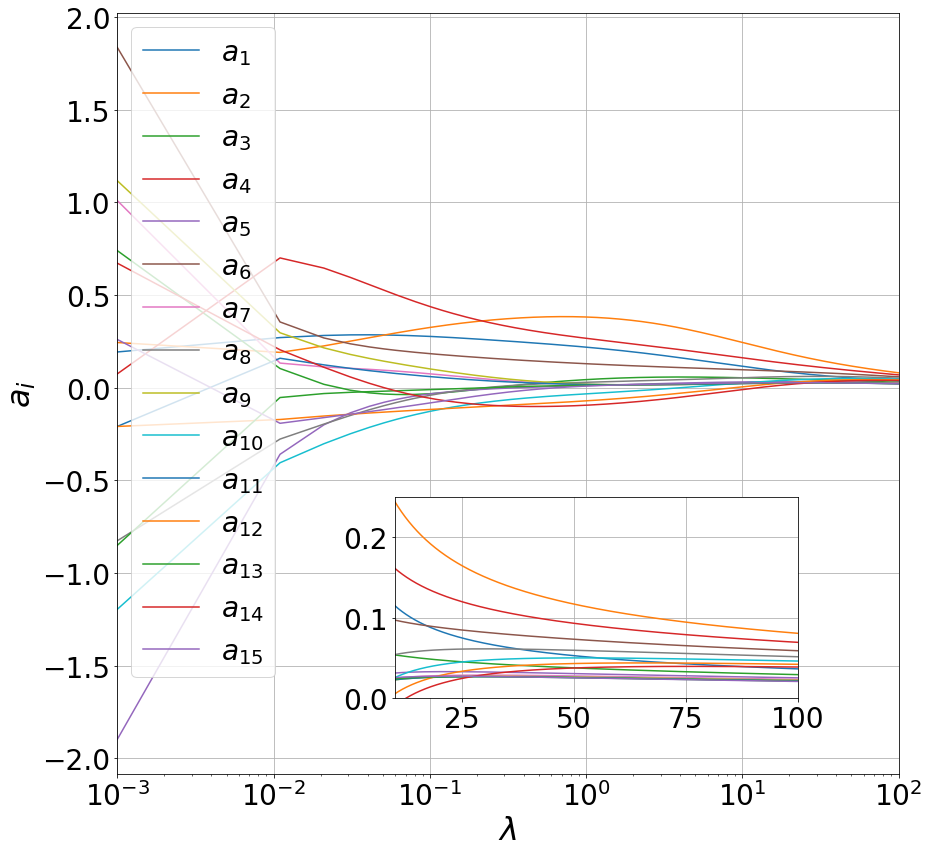

In [117]:
# Create figure.
# Plot weight.
plt.figure(figsize=(7,7))
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$a_i$', fontsize=18)
plt.legend(loc='upper right', fontsize=14)
plt.grid()
# Save figure.
plt.savefig('ridge_regression_weights.png', dpi=600)
# Show the plot.
plt.show()

# Plot norm.
plt.figure(figsize=(7,7))
plt.plot(lambdas, norm_hist[0,:])
plt.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$||a||_2^2$', fontsize=18)
plt.grid()
# Save figure.
plt.savefig('ridge_regression_l2_norm.png', dpi=600)
#Show the plot.
plt.show()

# Plot weight.
fig = plt.figure(figsize=(14,14))
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.tick_params(axis = 'both', which = 'both', labelsize = 28)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=32)
plt.ylabel('$a_i$', fontsize=32)
plt.legend(fontsize=28)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., fontsize=14)
plt.grid()
plt.xlim(1e-3,100)

left, bottom, width, height = [0.4, 0.2, 0.4, 0.2]
ax1 = fig.add_axes([left, bottom, width, height])
for i in range(0,model_order): 
    ax1.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
ax1.tick_params(axis = 'both', which = 'both', labelsize = 28)
ax1.set_xlim(10, 100)
ax1.set_ylim(0, 0.25)
ax1.grid()

# Save figure.
plt.savefig('ridge_regression_weightsv2.png', dpi=600)
# Show the plot.
plt.show()

ax.tick_params(reset=True)